In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
import numpy as np
np.random.seed(0)
import pandas as pd
import gc, os, time
import scipy as sp

from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
from sklearn.model_selection import cross_val_score

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression, VarianceThreshold

<a name='02'></a>
## 2. 데이터 읽기

데이터 파일을 불러옵니다.

In [2]:
# 학습용 데이터 
train_sensor = pd.read_csv('train_sensor.csv')
train_quality = pd.read_csv('train_quality.csv')
# 평가용 데이터 
predict_sensor = pd.read_csv('predict_sensor.csv')

In [3]:
def make_dataset(X, y=None):
    
    # -----------------------------------
    # train_sensor (X 인자)
    # -----------------------------------
    ''' column을 param_alias 로만 pivot table 만들기. '''
    df_X = X.copy()
    df_X = df_X.sort_values(by='end_time',ascending=True)
    df_X['step_id'] = df_X['step_id'].apply(lambda x: str(x).zfill(2))
    # step_id 와 param_alias 를 결합한 임시 컬럼 step_param 을 생성합니다. ex. 17_EPD_para4
    df_X['step_param'] = df_X[['step_id', 'param_alias']].apply(lambda x: '_'.join(x), axis=1)
    df_X_tmp = df_X.pivot_table(index = ['module_name','key_val'], columns = 'step_param', values='mean_val', aggfunc='sum')
    # 데이터 통합을 위해 인덱스를 key_val 로 재설정합니다. 
    df_X_tmp = df_X_tmp.reset_index(level=[0, 1])
    df_X_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # 시간 데이터 
    # -----------------------------------
    ''' step별 end_time을 column으로 pivot table 만들기 '''
    df_X['end_time_tmp'] = df_X.apply(lambda x: x['step_id'] + '_end_time', axis=1)
    df_X['end_time'] = pd.to_datetime(df_X['end_time'])
    # end_time 은 센서 데이터가 각 para 별로 서버에 도달한 시간으로 스텝 내 오차가 발생할 수 있습니다. 동일 스텝 구간내 공정 완료 시간이 다른 경우, min 함수를 사용하여 최초 수집된 time을 가져옵니다.
    df_time_tmp = df_X.pivot_table(index = ['key_val'], columns = 'end_time_tmp', values='end_time', aggfunc=lambda x : min(x.unique()))
    df_time_tmp = df_time_tmp.reset_index()
    df_time_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # train_quality (y 인자)
    # -----------------------------------

    if y is None : # 평가용 데이터 
        col_target = []
        col_idx = ['module_name', 'key_val']
        df_complete = pd.concat([df_X_tmp, df_time_tmp], axis=1).reset_index()
        df_complete.rename(columns={'index':'key_val'},inplace=True)
    else : # 학습용 데이터 
        df_y = y.copy()
        df_y.set_index('key_val', inplace=True)
        col_target = ['y']
        col_idx = ['module_name', 'key_val', 'end_dt_tm']
        # 센서 데이터, 시간데이터, 품질지표에 대하여 인덱스(key_val)기준으로 데이터프레임을 통합합니다.
        df_complete = pd.concat([df_X_tmp, df_time_tmp, df_y], axis=1).reset_index()
        # 컬럼 이름을 변경합니다.  
        df_complete.rename(columns={'msure_val':'y'}, inplace=True)
        df_complete.rename(columns={'index':'key_val'},inplace=True)


    # 컬럼 순서를 정렬합니다. 
    col_feats = df_X['step_param'].unique().tolist()
    col_feats.sort()
    col_time = [s for s in df_complete.columns.tolist() if "_end_time" in s]
    col_all = col_idx + col_target + col_feats + col_time
    df_complete = df_complete[col_all]
    # 처음 step이 시작된 시점을 기준으로 다시 정렬(APC value를 먹고 들어가는 값을 기준으로 정렬하고 싶었음.)
    df_complete = df_complete.set_index(['module_name','key_val','04_end_time']).sort_index(level=[0,2,1],ascending=True).reset_index()
    df_complete = df_complete[col_all]
    
    # 컬럼을 소문자로 변경합니다. 
    df_complete.columns = df_complete.columns.str.lower()

    return df_complete

In [4]:
# 학습용 데이터 
train = make_dataset(train_sensor, train_quality)
# 평가용 데이터 
predict = make_dataset(predict_sensor)

In [5]:
train.head()

module_name    key_val            end_dt_tm           y  04_efem_para2  \
0    EQ10_PM1    LOT5_21  2021-10-03 07:10:22  1260.08920      1631.2730   
1    EQ10_PM1  LOT126_21  2021-10-04 23:34:27  1253.30152      1627.9710   
2    EQ10_PM1   LOT23_21  2021-10-06 07:48:24  1248.55080      1631.0590   
3    EQ10_PM1  LOT295_21  2021-10-08 13:22:26  1260.24304      1628.5454   
4    EQ10_PM1   LOT75_18  2021-10-11 21:35:57  1257.05240      1629.9090   

   04_efem_para25  04_efem_para78  04_epd_para4  04_epd_para40  04_epd_para63  \
0       1639.7270        5.066540           0.0            0.0            0.0   
1       1641.1180        5.023404           0.0            0.0            0.0   
2       1643.8820        5.153204           0.0            0.0            0.0   
3       1640.6364        5.062904           0.0            0.0            0.0   
4       1639.3330        5.140881           0.0            0.0            0.0   

   ...  20_time_para9  20_time_para90  20_tmp_para31         04_end_time  \
0  ...      132.73330       2460.8170       3.399254 2021-10-02 22:14:27   
1  ...      166.26670       2494.3500       3.411500 2021-10-04 11:09:20   
2  ...      190.28330       2518.3670       3.413965 2021-10-05 14:23:04   
3  ...      246.76666       2574.8333       3.414677 2021-10-08 05:26:17   
4  ...      321.01670       2649.1000       3.407481 2021-10-11 15:17:36   

          06_end_time         12_end_time         13_end_time  \
0 2021-10-02 22:16:53 2021-10-02 22:30:59 2021-10-02 22:31:15   
1 2021-10-04 11:11:45 2021-10-04 11:25:52 2021-10-04 11:26:08   
2 2021-10-05 14:25:30 2021-10-05 14:39:37 2021-10-05 14:39:53   
3 2021-10-08 05:28:43 2021-10-08 05:42:50 2021-10-08 05:43:06   
4 2021-10-11 15:20:02 2021-10-11 15:34:08 2021-10-11 15:34:24   

          17_end_time         18_end_time         20_end_time  
0 2021-10-02 22:39:12 2021-10-02 22:39:28 2021-10-02 22:46:19  
1 2021-10-04 11:34:04 2021-10-04 11:34:20 2021-10-04 11:41:11  
2 2021-10-05 14:47:49 2021-10-05 14:48:05 2021-10-05 14:54:56  
3 2021-10-08 05:51:02 2021-10-08 05:51:18 2021-10-08 05:58:09  
4 2021-10-11 15:42:20 2021-10-11 15:42:36 2021-10-11 15:49:27  

[5 rows x 676 columns]

In [6]:
# -----------------------------------
# 3 장 EDA 분석에 필요한 변수를 선언합니다.
# -----------------------------------

# EDA를 위한 학습 데이터를 복사합니다.
df_eda = train.copy()

# 센서 컬럼과 날짜 컬럼을 정의합니다. 
col_sensor = df_eda.iloc[:, 4:-7].columns.tolist() 
col_time = df_eda.filter(regex='end').columns.tolist() 

assert len(col_sensor) == 665
assert len(col_time) == 8 

# 3.4절 공정 소요시간 분석에 필요한 변수를 정의합니다. 
lst_steps = ['04','06','12','13','17','18', '20']
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']

lst_sensors = []
for step in lst_steps:
    _ = [col for col in col_sensor if col[:2] == step]
    lst_sensors.append(_)

sensors_nm = list(map(lambda x: x[3:], lst_sensors[0]))

# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환합니다. 
df_eda[col_time] = df_eda[col_time].apply(pd.to_datetime)

In [7]:
# 전체 및 개별 공정 소요시간 변수를 생성하는 함수입니다.
def gen_duration_feats(df, lst_stepsgap):
    
    # 전체 공정 소요시간(초) 변수를 생성합니다. 
    df['gen_tmdiff'] = (df['20_end_time'] - df['04_end_time']).dt.total_seconds()
    
    # 개별 스텝간 공정 소요시간(초) 변수를 생성합니다. 
    # ex. gen_tmdiff_0406 : 04 스텝 공정 완료 시간과 06 스텝 공정 완료 시간의 차이 
    for stepgap in lst_stepsgap:
        df[f'gen_tmdiff_{stepgap}'] = (df[f'{stepgap[2:]}_end_time'] - df[f'{stepgap[:2]}_end_time']).dt.total_seconds()

    return df

전체 공정 소요시간은 최소 30.6분에서 최대 31.9분입니다. 

개별 스텝간 공정 소요시간도 확인하였을 시, 6번째 스텝에서 12번째 스텝 간 소요시간이 가장 길었습니다. 

<a name='04-01'></a>
### 4.1 내부 데이터를 통한 변수 생성 



In [38]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_prep_train = train.copy()
df_prep_predict = predict.copy()

In [39]:
# 전체 및 개별 공정 소요시간 7개의 변수를 생성합니다(3.4절)
df_prep_train = gen_duration_feats(df_prep_train, lst_stepsgap)
df_prep_predict = gen_duration_feats(df_prep_predict, lst_stepsgap)
df_prep_train.filter(regex='tmdiff').head(2)

gen_tmdiff  gen_tmdiff_0406  gen_tmdiff_0612  gen_tmdiff_1213  \
0      1912.0            146.0            846.0             16.0   
1      1911.0            145.0            847.0             16.0   

   gen_tmdiff_1317  gen_tmdiff_1718  gen_tmdiff_1820  
0            477.0             16.0            411.0  
1            476.0             16.0            411.0

### gen_tmdiff shift해서 차이 변수 만들기

In [42]:
gen_cols = df_prep_train.filter(regex='^gen').columns.tolist()

In [50]:
gen_shiftdiff1 = (df_prep_train[gen_cols] - df_prep_train.groupby('module_name')[gen_cols].shift(1)).fillna(0)
gen_shiftdiff1.columns = [col+'_shift1' for col in gen_shiftdiff1.columns]
gen_shiftdiff2 = (df_prep_train[gen_cols] - df_prep_train.groupby('module_name')[gen_cols].shift(2)).fillna(0)
gen_shiftdiff2.columns = [col+'_shift2' for col in gen_shiftdiff2.columns]
gen_shiftdiff2.head()

gen_tmdiff_shift2  gen_tmdiff_0406_shift2  gen_tmdiff_0612_shift2  \
0                0.0                     0.0                     0.0   
1                0.0                     0.0                     0.0   
2                0.0                     0.0                     1.0   
3                1.0                     1.0                     0.0   
4               -1.0                     0.0                    -1.0   

   gen_tmdiff_1213_shift2  gen_tmdiff_1317_shift2  gen_tmdiff_1718_shift2  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                    -1.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   gen_tmdiff_1820_shift2  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0

In [63]:
df1 = pd.concat([df_prep_train[['module_name','y']], gen_shiftdiff1],axis=1)

In [64]:
df2 = pd.concat([df_prep_train[['module_name','y']], gen_shiftdiff2],axis=1)

<Figure size 1080x1800 with 0 Axes>

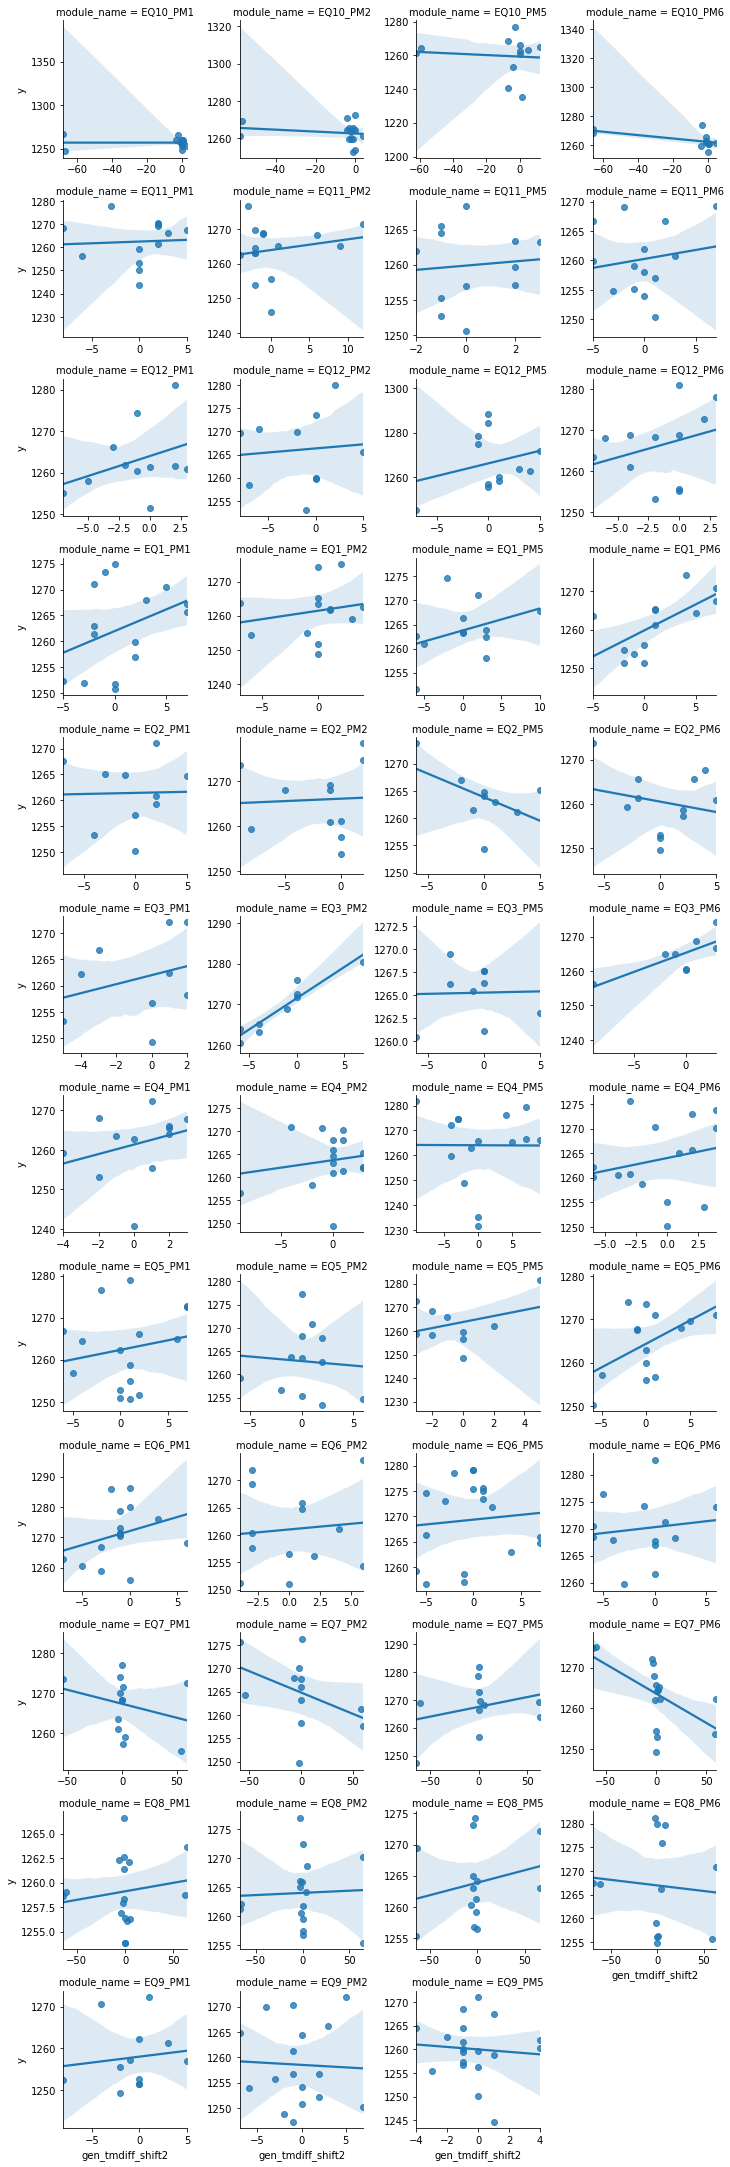

In [65]:
fig = plt.figure(figsize = (15, 25))
sns.lmplot(data = df2, x = 'gen_tmdiff_shift2', y = 'y', col = 'module_name', height = 2.5, aspect = 1,
          col_wrap = 4, sharey = False, sharex = False)

In [67]:
df_prep_train = pd.concat([df_prep_train, gen_shiftdiff1],axis=1)
df_prep_train = pd.concat([df_prep_train, gen_shiftdiff2],axis=1)
df_prep_train.head()

module_name    key_val            end_dt_tm           y  04_efem_para2  \
0    EQ10_PM1    LOT5_21  2021-10-03 07:10:22  1260.08920      1631.2730   
1    EQ10_PM1  LOT126_21  2021-10-04 23:34:27  1253.30152      1627.9710   
2    EQ10_PM1   LOT23_21  2021-10-06 07:48:24  1248.55080      1631.0590   
3    EQ10_PM1  LOT295_21  2021-10-08 13:22:26  1260.24304      1628.5454   
4    EQ10_PM1   LOT75_18  2021-10-11 21:35:57  1257.05240      1629.9090   

   04_efem_para25  04_efem_para78  04_epd_para4  04_epd_para40  04_epd_para63  \
0       1639.7270        5.066540           0.0            0.0            0.0   
1       1641.1180        5.023404           0.0            0.0            0.0   
2       1643.8820        5.153204           0.0            0.0            0.0   
3       1640.6364        5.062904           0.0            0.0            0.0   
4       1639.3330        5.140881           0.0            0.0            0.0   

   ...  gen_tmdiff_1317_shift1  gen_tmdiff_1718_shift1  \
0  ...                     0.0                     0.0   
1  ...                    -1.0                     0.0   
2  ...                     0.0                     0.0   
3  ...                     0.0                     0.0   
4  ...                     0.0                     0.0   

   gen_tmdiff_1820_shift1  gen_tmdiff_shift2  gen_tmdiff_0406_shift2  \
0                     0.0                0.0                     0.0   
1                     0.0                0.0                     0.0   
2                     0.0                0.0                     0.0   
3                     0.0                1.0                     1.0   
4                     0.0               -1.0                     0.0   

   gen_tmdiff_0612_shift2  gen_tmdiff_1213_shift2  gen_tmdiff_1317_shift2  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     1.0                     0.0                    -1.0   
3                     0.0                     0.0                     0.0   
4                    -1.0                     0.0                     0.0   

   gen_tmdiff_1718_shift2  gen_tmdiff_1820_shift2  
0                     0.0                     0.0  
1                     0.0                     0.0  
2                     0.0                     0.0  
3                     0.0                     0.0  
4                     0.0                     0.0  

[5 rows x 697 columns]

<a name='04-02'></a>
### 4.2 이상치 치환하기 

분위점을 임계값으로 삼아 이상치를 치환합니다. 

학습 데이터의 1%점을 하한, 99%점을 상한으로 잡고 해당 범위를 벗어나는 값을 각각 **하한값과 상한값으로 치환**합니다. 


In [68]:
# 기존 센서 변수(665개)와 생성 변수 중 수치형 변수(102개) 컬럼을 정의합니다. 
col_numerical = col_sensor

In [69]:
for col in col_numerical:
    # 열마다 학습 데이터의 1%, 99% 지점을 확인합니다.
    p05 = df_prep_train[col].quantile(0.05) 
    p95 = df_prep_train[col].quantile(0.95) 

    # 1%점 이하의 값은 1%점으로, 99%점 이상의 값은 99%점으로 클리핑합니다. 
    df_prep_train[col] = df_prep_train[col].clip(p05, p95)
    df_prep_predict[col] = df_prep_predict[col].clip(p05, p95)

# 소수점 첫째자리까지만 사용하기

In [11]:
df_prep_train.loc[:,col_numerical] = np.round(df_prep_train[col_numerical],1)
df_prep_predict.loc[:,col_numerical] = np.round(df_prep_predict[col_numerical],1)

In [37]:
df_prep_train.loc[:,col_numerical]

04_efem_para2  04_efem_para25  04_efem_para78  04_epd_para4  \
0        1631.2730       1639.7270        5.066540           0.0   
1        1627.9710       1641.1180        5.023404           0.0   
2        1631.0590       1643.8820        5.153204           0.0   
3        1628.5454       1640.6364        5.062904           0.0   
4        1629.9090       1639.3330        5.140881           0.0   
..             ...             ...             ...           ...   
606      1626.3530       1625.1770        4.944974           0.0   
607      1627.6970       1627.1820        5.014016           0.0   
608      1626.7270       1625.7270        5.412390           0.0   
609      1627.2122       1626.2122        5.400269           0.0   
610      1625.2727       1623.7878        5.047551           0.0   

     04_epd_para40  04_epd_para63  04_epd_para80  04_esc_para84  \
0              0.0            0.0            0.0         2999.0   
1              0.0            0.0            0.0         2999.0   
2              0.0            0.0            0.0         2999.0   
3              0.0            0.0            0.0         2999.0   
4              0.0            0.0            0.0         2999.0   
..             ...            ...            ...            ...   
606            0.0            0.0            0.0         2999.0   
607            0.0            0.0            0.0         2999.0   
608            0.0            0.0            0.0         2999.0   
609            0.0            0.0            0.0         2999.0   
610            0.0            0.0            0.0         2999.0   

     04_esc_para94  04_fr_para28  ...  20_time_para7  20_time_para75  \
0              0.0       -2999.0  ...      132.73330       2460.8170   
1              0.0       -2999.0  ...      166.26670       2494.3500   
2              0.0       -2999.0  ...      190.28330       2518.3670   
3              0.0       -2999.0  ...      246.76666       2574.8333   
4              0.0       -2999.0  ...      321.01670       2649.1000   
..             ...           ...  ...            ...             ...   
606            0.0       -2999.0  ...     1151.90000       1151.9000   
607            0.0       -2999.0  ...     1177.45000       1177.4500   
608            0.0       -2999.0  ...     1210.71700       1210.7170   
609            0.0       -2999.0  ...     1211.30000       1211.3000   
610            0.0       -2999.0  ...     1248.26670       1248.2667   

     20_time_para77  20_time_para8  20_time_para81  20_time_para83  \
0         2460.8170      132.73330       2460.8170       132.73330   
1         2494.3500      166.26670       2494.3500       166.26670   
2         2518.3670      190.28330       2518.3670       190.28330   
3         2574.8333      246.76666       2574.8333       246.76666   
4         2649.1000      321.01670       2649.1000       321.01670   
..              ...            ...             ...             ...   
606       1151.9000      415.96670       1151.9000       415.96670   
607       1177.4500      441.51670       1177.4500       441.51670   
608       1210.7170      474.78330       1210.7170       474.78330   
609       1211.3000      475.38333       1211.3000       475.38333   
610       1248.2667      512.33330       1248.2667       512.33330   

     20_time_para89  20_time_para9  20_time_para90  20_tmp_para31  
0         2460.8170      132.73330       2460.8170       3.399254  
1         2494.3500      166.26670       2494.3500       3.411500  
2         2518.3670      190.28330       2518.3670       3.413965  
3         2574.8333      246.76666       2574.8333       3.414677  
4         2649.1000      321.01670       2649.1000       3.407481  
..              ...            ...             ...            ...  
606       1151.9000      415.96670       1151.9000       3.479105  
607       1177.4500      441.51670       1177.4500       3.484577  
608       1210.7170      474.78330       1210.7170       3.492786

<a name='04-03'></a>
### 4.3 분산이 적은 변수 제거
분산 기준 설정(Variance Thresholding)은 가장 기본적인 특성 선택 방법 중 하나입니다. 

분산이 0 인 특징은 정보가 없으므로 해당 특징을 삭제합니다.

In [70]:
# threshold 인자를 변경하여 분산의 기준값을 수동으로 선택할 수 있습니다.
thresholder = VarianceThreshold(threshold=0)
_ = thresholder.fit_transform(df_prep_train[col_numerical])

 # 분산이 0이면 True 이므로 제거할 컬럼을 추출합니다.  
mask = ~thresholder.get_support()
cols_var_drop = np.asarray(col_numerical)[mask].tolist()
print(f'** {len(cols_var_drop)} Features to Drop by Low Variance')
print(f'{cols_var_drop}')

** 97 Features to Drop by Low Variance
['04_epd_para4', '04_epd_para40', '04_epd_para63', '04_epd_para80', '04_esc_para84', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_he_para1', '04_he_para95', '04_power_para14', '04_power_para49', '04_power_para57', '04_power_para68', '04_power_para82', '04_temp_para24', '04_time_para5', '06_epd_para80', '06_esc_para84', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_he_para1', '06_he_para95', '06_hv_para3', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para14', '06_power_para68', '06_power_para82', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_epd_para40', '12_epd_para63', '12_epd_para80', '12_esc_para84', '12_fr_para28', '12_fr_para69', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para68', '12_temp_para54', '13_epd_para4', '13_epd_para40', '13_epd_para63', '13_epd_para80', '13_esc_para84', '13_fr_para28', '13_fr_para69', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para68', '13_temp_pa

In [71]:
df_prep_train.drop(cols_var_drop, axis=1, inplace=True)
df_prep_predict.drop(cols_var_drop, axis=1, inplace=True)

<a name='04-06'></a>
### 4.6 변수 선택 

변수 선택은 주어진 데이터의 변수 중에서 모델링의 가장 적절한 변수만 선택하는 과정입니다. 

변수 선택 방법은 필터 방법(Filter method), 래퍼 방법(Wrapper method), 임베디드 방법(Embeded method)이 있습니다. 

- **필터 방법** : 통계량(ex. 상관계수, 카이제곱, 상호정보량)을 구하여 가장 뛰어난 특성을 선택하는 기법 (ex. SelectKBest)
- **래퍼 방법** : 시행착오를 통해 가장 높은 품질의 예측을 만드는 특성의 부분조합을 찾는 기법 (ex. RFE, RFECV)
- **임베디드 방법** : 결정트리 모델로부터 생성된 특징 중요도를 이용하여 특성을 선택하는 기법 (ex. SelectFromModel)

다음은 필터 방법중 상호정보량을 사용하여 중요 특성을 추출하는 예제코드입니다.

참가자들은 자유롭게 분석하며, 변수 선택 중 한가지 방법으로 참고할 수 있습니다.

In [45]:
# skb = SelectKBest(score_func=mutual_info_regression, k=100) 
# skb.fit(df_prep_train[col_sensor], df_prep_train['y'])
# select_features_kbest = skb.get_support()
# col_featsIDX = pd.Index(df_prep_train[col_sensor].columns.tolist())
# col_selected_mutual = col_featsIDX[select_features_kbest]

# Cyclic Transformation

In [73]:
''' Cyclic Transformation 적용 '''
def cyclic_transformation(df, cols):
    for col in cols:
        step = col[:2]
        df[col] = pd.to_datetime(df[col])
        df[step+'_'+'month'] = df[col].dt.month
        df[step+'_'+'day'] = df[col].dt.day
        df[step+'_'+'hour'] = df[col].dt.hour
        df[step+'_'+'weekday'] = df[col].dt.weekday
        
        ## cyclic transformation on hour
        df[step+'_'+'hour_sin'] = np.sin(2 * np.pi * df[step+'_'+'hour']/23.0)
        df[step+'_'+'hour_cos'] = np.cos(2 * np.pi * df[step+'_'+'hour']/23.0)
        ## cyclic transformation on date 
        df[step+'_'+'date_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        df[step+'_'+'date_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        ## cyclic transformation on month
        df[step+'_'+'month_sin'] = -np.sin(2 * np.pi * df[step+'_'+'month']/12.0)
        df[step+'_'+'month_cos'] = -np.cos(2 * np.pi * df[step+'_'+'month']/12.0)
        ## cyclic transformation on weekday
        df[step+'_'+'weekday_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        df[step+'_'+'weekday_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        
        df.drop(step+'_'+'month',axis=1,inplace=True)
        df.drop(step+'_'+'month_sin',axis=1,inplace=True)
        df.drop(step+'_'+'month_cos',axis=1,inplace=True)

In [74]:
endtime_col = df_prep_train.filter(regex='end_time$').columns.tolist()
cyclic_transformation(df_prep_train, endtime_col)
cyclic_transformation(df_prep_predict, endtime_col)

In [75]:
for_col_filter = []
for step_para in lst_sensors:
    for para in step_para:
        para = para.split('_')[0]+'_'+para.split('_')[1]
        for_col_filter.append(para)
for_col_filter = sorted(list(set(for_col_filter)))

In [76]:
''' 중복되는 열 제거하기. '''
drop_col = []
for para in for_col_filter:
    col = df_prep_train.filter(regex='^'+para).columns.tolist()
    if col:
        duplicate_deleted_df = df_prep_train[col].T.drop_duplicates(subset=df_prep_train[col].T.columns, keep='first').T
        if len(df_prep_train[col].columns.difference(duplicate_deleted_df.columns))==0:  # 다른게 없으면 무시,
            continue
        else:
            drop_col.extend(df_prep_train[col].columns.difference(duplicate_deleted_df.columns).tolist())
    else:
        continue
    
# 새로 생성한 TEST COLUMNS 중복 제거
# test_col = df_prep_train.filter(regex='test$').columns.tolist()
# duplicate_deleted_test_df = df_prep_train[test_col].T.drop_duplicates(subset=df_prep_train[test_col].T.columns, keep='first').T
# if len(df_prep_train[test_col].columns.difference(duplicate_deleted_test_df.columns))!=0:
#     drop_col.extend(df_prep_train[test_col].columns.difference(duplicate_deleted_test_df.columns).tolist())
    
df_prep_train.drop(drop_col,axis=1,inplace=True)
df_prep_predict.drop(drop_col, axis=1, inplace=True)
    
var0_cols = df_prep_train.loc[:,df_prep_train.nunique()==1].columns.tolist()
print(f'drop할 columns : {var0_cols}')
df_prep_train.drop(var0_cols, axis=1, inplace=True)
df_prep_predict.drop(var0_cols, axis=1, inplace=True)

drop할 columns : []


In [77]:
def prep_cate_feats(df_tr, df_te, feat_nm):

    df_merge = pd.concat([df_tr, df_te])

    # 컬럼명과 범주형 변수의 레벨명을 이용한 새로운 컬럼명을 자동생성합니다. 
    # ex. module_name_eq -> module_name_eq_EQ01, module_name_eq_EQ02, etc.
    df_merge = pd.get_dummies(df_merge, columns=[feat_nm])

    df_tr = df_merge.iloc[:df_tr.shape[0], :].reset_index(drop=True)
    df_te = df_merge.iloc[df_tr.shape[0]:, :].reset_index(drop=True)

    return df_tr, df_te

# module_name_eq 의 원-핫 인코딩 변수를 생성합니다.
df_train_ohe, df_predict_ohe = prep_cate_feats(df_prep_train, df_prep_predict, 'module_name')

<a name='05'></a>
## 5. 모델링

<a name='05-01'></a>
### 5.1 데이터 분할

모델의 일반화 성능을 평가하기 위해 학습 데이터 중 일부를 검증용 데이터로 분할합니다. 

train_test_split 함수를 이용하여 학습용 데이터 중 10% 데이터를 검증 데이터로 분류합니다.

In [80]:
# 학습에 사용할 수치형 변수 컬럼을 정의합니다. 
# 앞서 정의한 col_numerical 에서 분산이 0 인 컬럼을 제거합니다.
num_features = df_prep_train.columns[df_prep_train.dtypes==float].tolist()  # cyclic transformation, shift도 포함됨.
module_col = df_prep_train.filter(regex='module_name').columns.tolist()

# 학습에 사용할 원-핫 인코딩된 범주형 변수 컬럼을 정의합니다. 
col_ohe = df_train_ohe.filter(regex='^module_name').columns.tolist()

# 모델에 입력으로 사용될 최종 컬럼을 정의합니다. col_X, col_X_ohe에서 drop('y') 해야한다.
col_X_ohe = num_features + col_ohe
col_X = module_col + num_features
col_y = 'y'

# 학습용 데이터를 정의합니다.
x_train_raw = df_prep_train[col_X].drop('y',axis=1)   # cat용
x_train_ohe = df_train_ohe[col_X_ohe].drop('y',axis=1)   # xgb용
y_train_raw = df_prep_train[col_y]

col_X_ohe.remove('y')
col_X.remove('y')

# 평가용 데이터를 정의합니다.
# x_predict = df_prep_predict[col_X]   # cat용
# x_predict_ohe = df_predict_ohe[col_X_ohe]   # xgb용

In [23]:
with open('x_train_raw.p', 'wb') as f:
    pickle.dump(x_train_raw, f)
    
with open('x_train_ohe.p', 'wb') as f:
    pickle.dump(x_train_ohe, f)
    
with open('y_train_raw.p', 'wb') as f:
    pickle.dump(y_train_raw, f)
    
with open('x_predict.p', 'wb') as f:
    pickle.dump(x_predict, f)    

with open('x_predict_ohe.p', 'wb') as f:
    pickle.dump(x_predict_ohe, f)   

In [81]:
from catboost import CatBoostRegressor
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

In [82]:
# mean_squared_error 의 매개변수 squared 가 False 이면 RMSE 를 반환합니다.
def rmse(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred, squared=False), 4)

def objective(trial):
    params_xgb = {
        'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
        'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3,1.0),
#         'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.8),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int("max_depth", 4, 8),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'tree_method':'gpu_hist',
        'gpu_id':'0',
    }
    
    # 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
    x_train, x_valid, y_train, y_valid = train_test_split(x_train_ohe, y_train_raw, test_size=0.2, shuffle=True, random_state=71)

    model = xgb.XGBRegressor(**params_xgb, random_state=0)
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        early_stopping_rounds=35,
        verbose=False
    )

    xgb_pred = model.predict(x_valid)
    rmse_val = rmse(y_valid, xgb_pred)
    
    return rmse_val

In [83]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-23 20:23:54,821] A new study created in memory with name: xgb_parameter_opt


[20:23:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-23 20:24:01,221] Trial 0 finished with value: 7.6621 and parameters: {'booster': 'gblinear', 'reg_lambda': 0.5986584841970366, 'colsample_bytree': 0, 'learning_rate': 0.13325472594952487, 'n_estimators': 1644, 'max_depth': 4}. Best is trial 0 with value: 7.6621.
[I 2022-07-23 20:24:01,862] Trial 1 finished with value: 8.2 and parameters: {'booster': 'gbtree', 'reg_lambda': 0.020584494295802447, 'colsample_bytree': 0, 'learning_rate': 0.7762287832079756, 'n_estimators': 8342, 'max_depth': 5}. Best is trial 0 with value: 7.6621.
[I 2022-07-23 20:24:03,372] Trial 2 finished with value: 7.455 and parameters: {'booster': 'dart', 'reg_lambda': 0.5247564316322378, 'colsample_bytree': 0, 'learning_rate': 0.3512365647272715, 'n_estimators': 2983, 'max_depth': 7}. Best is trial 2 with value: 7.455.
[I 2022-07-23 20:24:04,441] Trial 3 finished with value: 7.6114 and parameters: {'booster': 'dart', 'reg_lambda': 0.45606998421703593, 'colsample_bytree': 0, 'learning_rate': 0.630289009500

[20:24:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-23 20:24:36,916] Trial 6 finished with value: 7.6892 and parameters: {'booster': 'gblinear', 'reg_lambda': 0.662522284353982, 'colsample_bytree': 0, 'learning_rate': 0.25625175011063467, 'n_estimators': 5249, 'max_depth': 6}. Best is trial 4 with value: 7.211.
[W 2022-07-23 20:24:37,114] Trial 7 failed because of the following error: ValueError("Input contains NaN, infinity or a value too large for dtype('float32').")
Traceback (most recent call last):
  File "C:\Users\xkdxk\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-82-e3a4de45e51f>", line 31, in objective
    rmse_val = rmse(y_valid, xgb_pred)
  File "<ipython-input-82-e3a4de45e51f>", line 3, in rmse
    return round(mean_squared_error(y_true, y_pred, squared=False), 4)
  File "C:\Users\xkdxk\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\xkdxk\anaconda3\lib\si

[20:24:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

# XGB CV로 

In [41]:
from sklearn.model_selection import KFold

In [54]:
# mean_squared_error 의 매개변수 squared 가 False 이면 RMSE 를 반환합니다.
def rmse(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred, squared=False), 4)

def objective(trial):
    params_xgb = {
        'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
        'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.8),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int("max_depth", 4, 12),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'tree_method':'gpu_hist',
        'gpu_id':'0'
    }

    model = xgb.XGBRegressor(**params_xgb, random_state=0)
    cv = KFold(5, shuffle=True, random_state=0)
    scores = cross_val_score(model, x_train_ohe, np.log1p(y_train_raw), cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmsle_val = np.mean(scores)
    
    return rmsle_val

In [55]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-23 19:22:02,780] A new study created in memory with name: xgb_parameter_opt


[19:22:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "tree_method" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "tr

[I 2022-07-23 19:22:20,470] Trial 0 finished with value: 0.027919996244537316 and parameters: {'booster': 'gblinear', 'reg_lambda': 0.5986584841970366, 'colsample_bytree': 0, 'learning_rate': 0.13325472594952487, 'n_estimators': 1644, 'max_depth': 4}. Best is trial 0 with value: 0.027919996244537316.


CV scores : [0.02854243 0.02603347 0.02360339 0.02943614 0.03198455]
Mean score :  0.027919996244537316


[I 2022-07-23 19:23:36,966] Trial 1 finished with value: 0.007609469028937471 and parameters: {'booster': 'gbtree', 'reg_lambda': 0.020584494295802447, 'colsample_bytree': 0, 'learning_rate': 0.7762287832079756, 'n_estimators': 8342, 'max_depth': 5}. Best is trial 1 with value: 0.007609469028937471.


CV scores : [0.00773299 0.00778652 0.00823549 0.00699608 0.00729627]
Mean score :  0.007609469028937471


KeyboardInterrupt: 

In [48]:
model_xgb = xgb.XGBRegressor(**study.best_params)
model_xgb.fit(x_train_raw, np.log1p(y_train_raw))

[17:10:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05880888585130287, max_delta_step=0, max_depth=9,
             min_child_weight=20, missing=nan, monotone_constraints='()',
             n_estimators=8167, n_jobs=12, num_parallel_tree=1,
             optimizer='dart', random_state=0, reg_alpha=0,
             reg_lambda=0.36438080296965675, scale_pos_weight=1,
             subsample=0.6662430932768539, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [56]:
model_xgb.feature_importances_

array([0.00030047, 0.00148553, 0.00084886, 0.0068627 , 0.        ,
       0.0012959 , 0.00058763, 0.00191967, 0.00100997, 0.00113142,
       0.00158519, 0.00038346, 0.00050771, 0.00403938, 0.00179635,
       0.00130149, 0.00106223, 0.00069497, 0.00076786, 0.00193225,
       0.00101863, 0.00064243, 0.00218114, 0.00215003, 0.00071969,
       0.00075374, 0.00088671, 0.00244134, 0.00181841, 0.00413609,
       0.0004505 , 0.00158508, 0.00176675, 0.00122761, 0.00108257,
       0.        , 0.00030886, 0.0012859 , 0.00271776, 0.0050327 ,
       0.00303157, 0.00224006, 0.00152639, 0.00043652, 0.00087303,
       0.00309779, 0.0002508 , 0.00064573, 0.00022425, 0.00261976,
       0.0019635 , 0.00371463, 0.00054421, 0.00054687, 0.0012898 ,
       0.00142785, 0.00135913, 0.00045424, 0.0007535 , 0.00169372,
       0.00281169, 0.0002636 , 0.00450448, 0.00016596, 0.0007811 ,
       0.00030095, 0.00124027, 0.00099433, 0.00036033, 0.00163742,
       0.00038569, 0.001405  , 0.00123841, 0.00028613, 0.00184

In [54]:
feat_importances = pd.Series(model_xgb.feature_importances_, index=df_prep_train[col_X].columns)
plt.figure(figsize=(20,15))
feat_importances.nlargest(50).plot(kind='barh')

AttributeError: 'numpy.ndarray' object has no attribute 'sort_values'

In [33]:
df_prep_train.head()

key_val            end_dt_tm           y  04_efem_para2  04_efem_para25  \
0    LOT5_21  2021-10-03 07:10:22  1260.08920      1631.2730       1639.7270   
1  LOT126_21  2021-10-04 23:34:27  1253.30152      1627.9710       1641.1180   
2   LOT23_21  2021-10-06 07:48:24  1248.55080      1631.0590       1643.8820   
3  LOT295_21  2021-10-08 13:22:26  1260.24304      1628.5454       1640.6364   
4   LOT75_18  2021-10-11 21:35:57  1257.05240      1629.9090       1639.3330   

   04_efem_para78  04_epd_para4  04_epd_para40  04_epd_para63  04_epd_para80  \
0        5.066540           0.0            0.0            0.0            0.0   
1        5.023404           0.0            0.0            0.0            0.0   
2        5.153204           0.0            0.0            0.0            0.0   
3        5.062904           0.0            0.0            0.0            0.0   
4        5.140881           0.0            0.0            0.0            0.0   

   ...  module_name_EQ7_PM2  module_name_EQ7_PM5  module_name_EQ7_PM6  \
0  ...                    0                    0                    0   
1  ...                    0                    0                    0   
2  ...                    0                    0                    0   
3  ...                    0                    0                    0   
4  ...                    0                    0                    0   

   module_name_EQ8_PM1  module_name_EQ8_PM2  module_name_EQ8_PM5  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   module_name_EQ8_PM6  module_name_EQ9_PM1  module_name_EQ9_PM2  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   module_name_EQ9_PM5  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 729 columns]

# CATBOOST

In [ ]:
with open('x_train_raw.p', 'wb') as f:
    pickle.dump(x_train_raw, f)
    
with open('x_train_ohe.p', 'wb') as f:
    pickle.dump(x_train_ohe, f)
    
with open('y_train_raw.p', 'wb') as f:
    pickle.dump(y_train_raw, f)
    
with open('x_predict.p', 'wb') as f:
    pickle.dump(x_predict, f)    

with open('x_predict_ohe.p', 'wb') as f:
    pickle.dump(x_predict_ohe, f)   

In [1]:
import pickle

In [6]:
with open('x_train_raw.p', 'rb') as f:
    x_train_raw = pickle.load(f)
    
with open("x_train_ohe.p","rb") as f:    
    x_train_ohe = pickle.load(f)
    
with open("y_train_raw.p","rb") as f:    
    y_train_raw = pickle.load(f)
    
with open("x_predict.p","rb") as f:    
    x_predict = pickle.load(f)
    
with open("x_predict_ohe.p","rb") as f:    
    x_predict_ohe = pickle.load(f)

SyntaxError: invalid character in identifier (<ipython-input-6-ccc739de6bae>, line 1)

In [24]:
def objective_CAT(trial):
    param = {
      "random_state":42,
      'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.8),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
#       "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 12),
      'random_strength' :trial.suggest_int('random_strength', 0, 30),
#       "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 400),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
      'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
        'task_type':'GPU',
        'devices':'0'
  }
    
    x_train, x_valid, y_train, y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.2, shuffle=True, random_state=71)
  
    cat = CatBoostRegressor(loss_function='RMSE',**param, eval_metric='RMSE')
    cat.fit(x_train, y_train,
            eval_set=[(x_valid,y_valid)],
            early_stopping_rounds=20, cat_features = module_col,
            verbose=100)
    cat_pred = cat.predict(x_valid)
    rmsle_val = np.sqrt(mean_squared_error(y_valid, cat_pred))

    return rmsle_val

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective_CAT, n_trials=20)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)
# 6.36 -> 9.4 됨.

[I 2022-07-23 18:46:24,644] A new study created in memory with name: cat_parameter_opt


0:	learn: 8.3426318	test: 7.5665186	best: 7.5665186 (0)	total: 6.22ms	remaining: 6.22s
bestTest = 7.565345098


[I 2022-07-23 18:46:25,764] Trial 0 finished with value: 7.565347167522934 and parameters: {'learning_rate': 0.3058866938894164, 'bagging_temperature': 63.512210106407046, 'max_depth': 10, 'random_strength': 18, 'l2_leaf_reg': 4.688999026868671e-06, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain'}. Best is trial 0 with value: 7.565347167522934.


bestIteration = 16
Shrink model to first 17 iterations.
0:	learn: 8.1039815	test: 7.5722301	best: 7.5722301 (0)	total: 11.2ms	remaining: 11.2s


[I 2022-07-23 18:46:26,411] Trial 1 finished with value: 7.421731388342937 and parameters: {'learning_rate': 0.7762287832079756, 'bagging_temperature': 21.368329072358772, 'max_depth': 5, 'random_strength': 5, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 305, 'od_type': 'IncToDec', 'boosting_type': 'Plain'}. Best is trial 1 with value: 7.421731388342937.


bestTest = 7.421727507
bestIteration = 2
Shrink model to first 3 iterations.
0:	learn: 7.8255473	test: 7.5870975	best: 7.5870975 (0)	total: 26.8ms	remaining: 26.7s


[I 2022-07-23 18:46:28,060] Trial 2 finished with value: 7.29846538120473 and parameters: {'learning_rate': 0.24079427234282236, 'bagging_temperature': 0.2920433847181412, 'max_depth': 8, 'random_strength': 24, 'l2_leaf_reg': 5.998216726929208e-06, 'min_child_samples': 54, 'max_bin': 319, 'od_type': 'Iter', 'boosting_type': 'Plain'}. Best is trial 2 with value: 7.29846538120473.


bestTest = 7.298466269
bestIteration = 24
Shrink model to first 25 iterations.


In [ ]:
cat = CatBoostRegressor(loss_function='RMSE',**study.best_params, eval_metric='RMSE')
cat.fit(x_train_raw, np.log1p(y_train_raw),early_stopping_rounds=35,
            verbose=100,validation_split=0.2)

# RandomForestRegressor

In [18]:
def RF_objective(trial):
    rf_params={
        'max_depth' : trial.suggest_int('max_depth', 1, 10),
        'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
        'n_estimators' :  trial.suggest_int('n_estimators', 100, 500),
        'max_features': trial.suggest_int('max_depth', 1, 100)
    }
    
   
    model = RandomForestRegressor(**rf_params,
                                   n_jobs=2,
                                   random_state=25)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train_raw, np.log1p(y_train_raw), test_size=0.2, shuffle=True, random_state=71)
    model.fit(x_train, y_train)    
    score = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_squared_error")
    score = np.sqrt(-score)
    rmse_mean = score.mean()

    return rmse_mean

In [19]:
sampler = TPESampler(seed=42)
study_rf = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study_rf.optimize(RF_objective, n_trials=20)
print("Best Score:", study_rf.best_value)
print("Best trial:", study_rf.best_trial.params)
# 6.36 -> 9.4 됨.

[I 2022-07-08 17:48:11,986] A new study created in memory with name: rf_parameter_opt
[I 2022-07-08 17:48:13,942] Trial 0 finished with value: 0.006373167458994991 and parameters: {'max_depth': 4, 'max_leaf_nodes': 951, 'n_estimators': 393}. Best is trial 0 with value: 0.006373167458994991.
[I 2022-07-08 17:48:15,021] Trial 1 finished with value: 0.006339693119663979 and parameters: {'max_depth': 6, 'max_leaf_nodes': 157, 'n_estimators': 162}. Best is trial 1 with value: 0.006339693119663979.
[I 2022-07-08 17:48:16,496] Trial 2 finished with value: 0.006544511082067146 and parameters: {'max_depth': 1, 'max_leaf_nodes': 867, 'n_estimators': 341}. Best is trial 1 with value: 0.006339693119663979.
[I 2022-07-08 17:48:19,217] Trial 3 finished with value: 0.006345813300905376 and parameters: {'max_depth': 8, 'max_leaf_nodes': 22, 'n_estimators': 488}. Best is trial 1 with value: 0.006339693119663979.
[I 2022-07-08 17:48:20,463] Trial 4 finished with value: 0.006329233147620195 and parameter

KeyboardInterrupt: 

In [ ]:
model_rf = RandomForestClassifier(**study_rf.best_params, n_jobs=2, random_state=25)
model_rf.fit(x_train_raw, np.log1p(y_train_raw))

In [ ]:
#Create an instance with tuned hyperparameters
optimized_RF = RandomForestClassifier(max_depth = RF_study.best_params['max_depth'], max_leaf_nodes = RF_study.best_params['max_leaf_nodes'],
                                      n_estimators = RF_study.best_params['n_estimators'],n_jobs=2,random_state=25)

In [ ]:
xgb_pred = np.exp(model_xgb.predict(x_predict))
cat_pred = np.exp(cat.predict(x_predict))
rf_pred = np.exp(model_rf.predict(x_predict))

y_pred_xgbcat= np.mean([xgb_pred, cat_pred], axis=0)
y_pred_xgbrf= np.mean([xgb_pred, rf_pred], axis=0)
y_pred_catrf= np.mean([cat_pred, rf_pred], axis=0)
y_pred_all = np.mean([xgb_pred,cat_pred,rf_pred], axis=0)

<a name='05-02'></a>
### 5.2 릿지 회귀 모델
선형 모델 중 하나인 릿지 모델을 사용합니다. 릿지 모델은 계수의 제곱에 비례하여 벌칙을 부여하는 **L2 정규화**를 사용합니다. 

릿지 회귀 모델에서 튜닝해야할 매개변수는 정규화의 세기를 나타내는 **alpha** 입니다.  


In [48]:
# log 단위(1e+01)로 1.e-02 ~ 1.e+01 구간에 대해 매개변수를 탐색합니다.
ridge_params = {'alpha': np.logspace(-2,1,6)}

매개변수 탐색을 위해 그리드 서치 기법을 사용합니다. 

GridSearchCV는 매개변수 각 조합에 대해 모델을 훈련하고, K-폴드 교차검증으로 평가합니다. cv의 디폴트는 5 입니다. 

refit=True 로 설정할 경우, 매개변수 탐색 후, 전체 데이터셋에서 최적의 하이퍼파라미터를 사용하여 모델을 재학습시킵니다.

In [49]:
# GridSearchCV를 이용하여 Ridge 모델을 저장합니다.
ridge_model = GridSearchCV(Ridge(), param_grid=ridge_params, refit=True, scoring='neg_root_mean_squared_error')
ridge_model.fit(x_train, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([ 0.01      ,  0.03981072,  0.15848932,  0.63095734,  2.51188643,
       10.        ])},
             scoring='neg_root_mean_squared_error')

alpha 가 10인 경우, 모델의 성능이 가장 우수하였습니다.

In [50]:
col_cv_results = ['params', 'mean_test_score', 'rank_test_score']
pd.DataFrame(ridge_model.cv_results_)[col_cv_results]

params  mean_test_score  rank_test_score
0                  {'alpha': 0.01}       -20.287627                6
1  {'alpha': 0.039810717055349734}       -16.410759                5
2   {'alpha': 0.15848931924611134}       -12.788945                4
3     {'alpha': 0.630957344480193}       -10.298752                3
4    {'alpha': 2.5118864315095797}        -9.043420                2
5                  {'alpha': 10.0}        -8.540584                1

<a name="05-03"></a>
### 5.3 랜덤 포레스트 모델 
랜덤 포레스트는 행 데이터를 샘플링한 후, 병렬로 수행된 다수의 결정 트리로부터 예측한 평균값을 출력합니다. 

랜덤 포레스트에서 튜닝해야할 변수는 다음과 같습니다.

*  n_estimators : 결정 트리 갯수 ( default : 100 )
*  max_depth : 트리의 최대 깊이 ( default : None ) 
*  min_samples_split : 노드를 분할하기 위한 최소 샘플 갯수 ( default : 2 )
*  min_samples_leaf : 리프 노드가 되기 위한 최소 샘플 갯수 ( default : 1 )
*  max_features : 각 노드에서 분기시 사용할 최대 특성 갯수 ( default : 1.0 - 전체 특성 갯수 )
*  bootstrap : 중복을 허용한 샘플링 여부 ( default : True ) 


결정 트리의 갯수가 커질수록 계산시간이 증가하므로, 시간과 성능의 트레이드 오프로 결정합니다. 

In [51]:
rf_params = {'n_estimators': [120, 200], 'max_features' : [5, 6]} 

# GridSearchCV를 이용하여 Randomforest 모델을 저장합니다.
rf_model = GridSearchCV(RandomForestRegressor(), param_grid=rf_params, scoring='neg_root_mean_squared_error')
rf_model.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_features': [5, 6], 'n_estimators': [120, 200]},
             scoring='neg_root_mean_squared_error')

In [52]:
pd.DataFrame(rf_model.cv_results_)[col_cv_results]

params  mean_test_score  rank_test_score
0  {'max_features': 5, 'n_estimators': 120}        -7.459335                3
1  {'max_features': 5, 'n_estimators': 200}        -7.405403                1
2  {'max_features': 6, 'n_estimators': 120}        -7.425194                2
3  {'max_features': 6, 'n_estimators': 200}        -7.468703                4

<a name='05-04'></a>
### 5.4 최종 모델 구축 

릿지 모델과 랜덤 포레스트 모델을 평가하고, 이 둘의 조합인 앙상블 모델을 구축합니다.


In [53]:
# 최적의 하이퍼파라미터로 학습된 릿지 회귀 모델을 저장합니다. 
best_ridge = ridge_model.best_estimator_

# 최적의 하이퍼파라미터로 학습된 랜덤포레스트 모델을 저장합니다. 
best_rf = rf_model.best_estimator_

# 학습용 데이터셋의 타깃 변수 예측 
y_pred_tr_ridge = best_ridge.predict(x_train)
y_pred_tr_rf = best_rf.predict(x_train)

# 검증용 데이터셋의 타깃 변수 예측 
y_pred_va_ridge = best_ridge.predict(x_valid)
y_pred_va_rf = best_rf.predict(x_valid)

# 평가용 데이터셋의 타깃 변수 예측 
y_pred_te_ridge = best_ridge.predict(x_predict)
y_pred_te_rf = best_rf.predict(x_predict)

# 앙상블 모형의 학습 및 검증 데이터에 대한 타깃 변수 예측 
y_pred_tr_en= np.mean([y_pred_tr_ridge, y_pred_tr_rf], axis=0)
y_pred_va_en= np.mean([y_pred_va_ridge, y_pred_va_rf], axis=0)
y_pred_te_en= np.mean([y_pred_te_ridge, y_pred_te_rf], axis=0)

# 학습 데이터셋의 RMSE 계산 
rmse_tr_ridge = rmse(y_train, y_pred_tr_ridge)
rmse_tr_rf = rmse(y_train, y_pred_tr_rf)
rmse_tr_en = rmse(y_train, y_pred_tr_en)

# 검증 데이터셋의 RMSE 계산 
rmse_va_ridge = rmse(y_valid, y_pred_va_ridge)
rmse_va_rf = rmse(y_valid, y_pred_va_rf)
rmse_va_en = rmse(y_valid, y_pred_va_en)

print(f'\n**** RIDGE\n')
print(f'Train RMSE: {round(rmse_tr_ridge, 4)}\n')
print(f'Valid RMSE: {round(rmse_va_ridge, 4)}')

print(f'\n**** Random Forest\n')
print(f'Train RMSE: {round(rmse_tr_rf, 4)}\n')
print(f'Valid RMSE: {round(rmse_va_rf, 4)}')

print(f'\n**** Ensemble\n\n')
print(f'Train RMSE: {round(rmse_tr_en, 4)}\n')
print(f'Valid RMSE: {round(rmse_va_en, 4)}')


**** RIDGE

Train RMSE: 4.4085

Valid RMSE: 8.5523

**** Random Forest

Train RMSE: 2.7155

Valid RMSE: 7.6214

**** Ensemble


Train RMSE: 3.3539

Valid RMSE: 7.5195


검증용 데이터로 세가지 모델에 대한 성능을 비교합니다.

(5.0, 9.0)

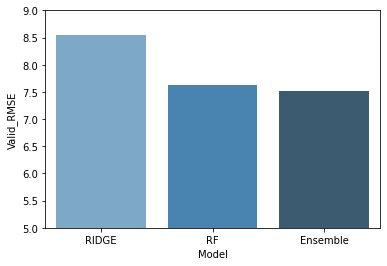

In [54]:
rmse_valid = [rmse_va_ridge, rmse_va_rf, rmse_va_en]
recap_model = ['RIDGE', 'RF', 'Ensemble']
df_recap = pd.DataFrame({'Model': recap_model, 'Valid_RMSE' : rmse_valid})
ax = sns.barplot(x='Model', y='Valid_RMSE', data=df_recap, palette="Blues_d")
ax.set_ylim([5, 9]) 

검증 데이터에 대한 앙상블 모델 예측 결과를 시각화합니다. 

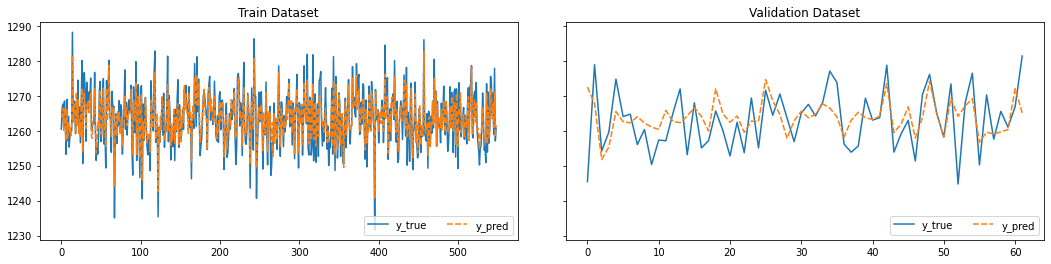

<Figure size 432x288 with 0 Axes>

In [55]:
df_train = pd.DataFrame({'y_true': y_train.values, 'y_pred': y_pred_tr_en})
df_valid = pd.DataFrame({'y_true': y_valid.values, 'y_pred': y_pred_va_en})

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18,4))
fig.subplots_adjust(hspace=.4, wspace=.1)

sns.lineplot(data = df_train, ax=axes[0])
sns.lineplot(data = df_valid, ax=axes[1])

axes[0].set_title('Train Dataset')
axes[1].set_title('Validation Dataset')

axes[0].legend(loc='lower right', ncol=2)
axes[1].legend(loc='lower right', ncol=2)

plt.show()
plt.clf() 

<a name='05-05'></a>
### 5.5 결과 해석 


릿지 회귀 모델에서의 계수(coefficient)는 각 변수의 곱해지는 가중치를 의미합니다.

In [56]:
# Ridge 에서 GridSearchCV로 탐색한 최적의 alpha값 출력합니다. 
print(f'Alpha : {best_ridge.alpha}')
_ = pd.DataFrame(best_ridge.coef_.reshape(-1, df_prep_train[col_X].columns.shape[0]), columns=df_prep_train[col_X].columns, index=['coefficient'])
_

Alpha : 10.0


04_efem_para2  04_efem_para25  04_efem_para78  04_esc_para94  \
coefficient      -0.267602       -0.144311       -0.467995       0.740078   

             04_fr_para28  04_fr_para61  04_gas_para10  04_gas_para13  \
coefficient     -0.760696     -0.042781      -0.571897       0.227714   

             04_gas_para15  04_gas_para19  ...  module_name_eq_EQ11  \
coefficient       0.661715       0.823667  ...            -0.382013   

             module_name_eq_EQ12  module_name_eq_EQ2  module_name_eq_EQ3  \
coefficient            -1.006414           -0.932351           -0.154557   

             module_name_eq_EQ4  module_name_eq_EQ5  module_name_eq_EQ6  \
coefficient             0.30164            0.444675            0.915384   

             module_name_eq_EQ7  module_name_eq_EQ8  module_name_eq_EQ9  
coefficient            0.175327            -0.31973            0.060051  

[1 rows x 693 columns]

랜덤 포레스트와 같은 트리 기반 모델에서는 각 변수의 중요도 정보를 함께 제공합니다. 

특정 변수로 분기되었을 시 제곱오차(squared_error)가 크게 감소한 변수일수록 중요도가 높아집니다.

분류 문제일 경우에는, 불순도(Gini, entropy)가 크게 감소할수록 해당 특성의 중요도가 높아집니다.

전체 변수의 중요도 합은 1이며, 이는 상대적 의미를 가집니다.  



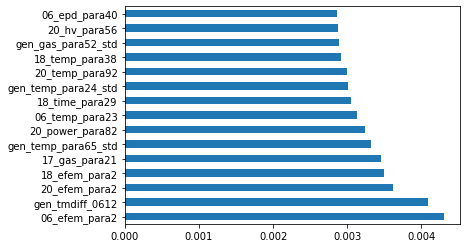

In [57]:
feat_importances = pd.Series(best_rf.feature_importances_, index=df_prep_train[col_X].columns)
feat_importances.nlargest(15).plot(kind='barh')

<a name='05-06'></a>
### 5.6 예측 결과 파일 제출 

In [58]:
predict['msure_val'] = list(y_pred_te_en)
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

key_val    msure_val
0  LOT122_18  1259.871306
1  LOT313_18  1260.350538
2  LOT380_17  1259.383758
3  LOT459_12  1259.843852
4  LOT459_18  1260.857781

In [59]:
# 예측값에 결측치가 포함되어 있는지 확인합니다.
df_submission.isnull().sum()

key_val      0
msure_val    0
dtype: int64

In [60]:
# 예측값의 갯수가 평가용 데이터의 갯수와 동일한지 확인합니다.
assert len(df_submission) == len(predict)
print(f'No. of Predict DataSet : {len(predict)}\nNo. of Submission DataSet : {len(df_submission)}')

No. of Predict DataSet : 262
No. of Submission DataSet : 262


In [61]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv(f'{path}cds_submission_MyTeam_1.csv')